## **회귀 실습 - 자전거 대여 수요 예측**

- **필요 패키지 가져오기**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv('bike_train.csv')
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


#### **자료 정보**
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather (1: Clear, Few clouds, Partly cloudy, Partly cloudy / 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist / 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds / 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
# null 데이터 유무 확인
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [11]:
# object형태인 데이트타임을 datetime 타입으로 변경해주기
df['datetime'] = df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시 추출
df['year'] = df.datetime.apply(lambda x: x.year)
df['month'] = df.datetime.apply(lambda x: x.month)
df['day'] = df.datetime.apply(lambda x: x.day)
df['hour'] = df.datetime.apply(lambda x: x.hour)
df.tail(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,2012,12,19,23


In [14]:
columns=['datetime', 'casual', 'registered']
df.drop(columns, axis=1, inplace=True)
df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


#### **예측 성능 측정**

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y - log_pred) ** 2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val=rmsle(y, pred)
    rmse_val=rmse(y, pred)
    mae_val=mean_absolute_error(y, pred)
    print('RMSLE:{0:.3f}, RMSE:{1:.3f}, MAE:{2:.3f}'.format(rmsle_val, rmse_val, mae_val))

#### **로그변환, 피처 인코딩 + 모델 학습/예측/평가**

In [36]:
# 선형회귀로 회귀 예측
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = df['count']
X_features = df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.3, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE:1.165, RMSE:140.900, MAE:105.924


In [37]:
# 실제 대여 횟수와 오류가 크기 때문에 실제와 얼마나 차이나는지 확인
# 오류 값이 가장 큰 순서대로 10개를 데이터프레임으로 확인
def get_top_error_data(y_test, pred, n_tops=10):
    result_df=pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df.real_count - result_df.predicted_count)

    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=10)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0
2277         813            267.0  546.0
2314         766            222.0  544.0
454          721            177.0  544.0
1003         713            171.0  542.0
2394         684            142.0  542.0


예측 오류가 큰 편. 회귀에서 큰 예측 오류가 발생하는 경우에는 target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이 가장 먼저. target 값의 분포는 정규분포 형태가 가장 좋음.

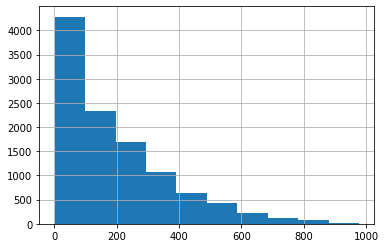

In [38]:
# hist()를 이용해 자전거 대여 모델의 target값인 count 컬럼이 정규 분포를 이루는지 확인
y_target.hist()

- 0~200 사이에 왜곡되어 있음. 이런 경우 **로그**를 적용해 변환하는 것이 가장 일반적임

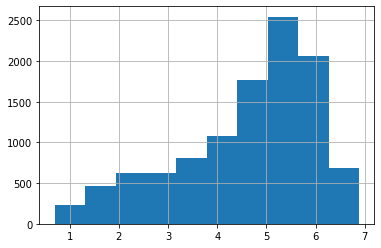

In [40]:
y_log_trf = np.log1p(y_target)
y_log_trf.hist()

- 완전한 정규분포 형태는 아니지만 변환 전보다는 왜곡 정도가 완화됨
- 이를 이용해 다시 학습한 후 평가를 수행

In [41]:
y_target_log = np.log1p(y_target)

# 로그 값으로 학습/ 데이터세트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target_log, test_size=0.3, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# 테스트데이터세트의 target 값은 로그 변환되었으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE:1.017, RMSE:162.594, MAE:109.286


* **RMSLE:1.165, RMSE:140.900, MAE:105.924**
* **RMSLE:1.017, RMSE:162.594, MAE:109.286**
- 로그 변환 이전과 비교하면 RMSE는 오히려 오류가 크게 늘어남

#### **각 피처의 회귀계수 값 시각화**

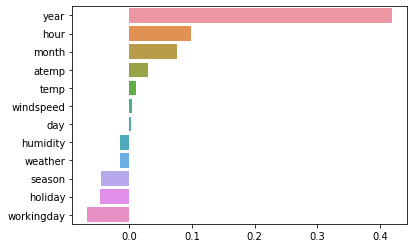

In [42]:
coef = pd.Series(lr.coef_, index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [47]:
# year의 회귀계수 값이 큼. (year 피쳐는 연도이므로 숫자형 값으로 되어 있음.)
# 사이킷런은 카테고리만을 위한 데이터타입이 없으며 모두 숫자로 변환해야 함.
# 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀계수를 연산할 때 이 숫자형 값에 크게 영향을 받을 수 있음
# 따라서 이런 값은 원 핫 인코딩을 적용해 변환해야 함

X_features_oh = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

In [48]:
# 원핫인코딩이 적용된 피처 데이터세트 기반으로 학습/ 예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_features_oh, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터세트를 입력하면 성능 평가 수치를 반환

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('🧡',model.__class__.__name__,'🧡')
    evaluate_regr(y_test, pred)

# 모델별로 평가 수행
lr = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.01)

for model in [lr, ridge, lasso]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

🧡 LinearRegression 🧡
RMSLE:0.590, RMSE:97.688, MAE:63.382
🧡 Ridge 🧡
RMSLE:0.590, RMSE:98.529, MAE:63.893
🧡 Lasso 🧡
RMSLE:0.635, RMSE:113.219, MAE:72.803


- **회귀계수 상위 25개 피쳐 추출**

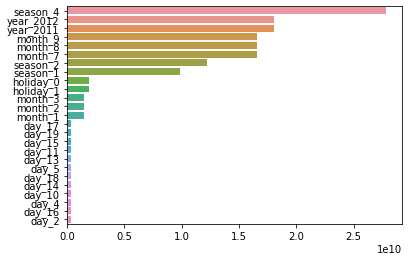

In [49]:
coef = pd.Series(lr.coef_, index=X_features_oh.columns)
coef_sort = coef.sort_values(ascending=False)[:25]
sns.barplot(x=coef_sort.values, y=coef_sort.index)